In [1]:
from pydantic import Field, BaseModel
import torch
import numpy as np
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, RichProgressBar
from monai.networks.nets import UNet

from ketsu.utils.cli import BaseMLCLI, BaseMLArgs
from ketsu.datasets import ConjDataset
from ketsu.main import ConjConfig, ConjModule, CustomEarlyStopping

pl.seed_everything(0)
torch.set_float32_matmul_precision('medium')

Seed set to 0


In [2]:


class TrainArgs(ConjConfig):
    batch_size: int = Field(10, s='-B')
    num_workers: int = 4
    checkpoint_dir: str = 'checkpoints'
    experiment_name: str = Field('{arch_name}', l='--exp')
    size: int = 512


# encoder:VGG16 deocder: Nearest, BS: 5, lr: 0.00001
# 転移学習なので学習率を下げる
a = TrainArgs(arch_name='unet16n', batch_size=5, lr=0.0001)
print(a)

checkpoint_dir = os.path.join(
    a.checkpoint_dir,
    a.experiment_name.format(**a.model_dump())
)

os.makedirs(checkpoint_dir, exist_ok=True)

train_ds = ConjDataset(mode='train', augmentation=True)
val_ds = ConjDataset(mode='val', augmentation=False)
train_loader = DataLoader(train_ds, a.batch_size, num_workers=a.num_workers, shuffle=True)
val_loader = DataLoader(val_ds, a.batch_size, num_workers=a.num_workers)

checkpoint = ModelCheckpoint(
    monitor='val_loss',
    dirpath=checkpoint_dir,
    filename='{epoch:02d}-{val_loss:.3f}',
    save_top_k=1,
    mode='min',
    save_weights_only=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    verbose=True
)

trainer = pl.Trainer(
    max_epochs=100,
    devices=1,
    accelerator='gpu',
    callbacks=[checkpoint, early_stopping],
    log_every_n_steps=1,
    logger=True,
)


config = ConjConfig(**a.model_dump())
print('config', config)
module = ConjModule(config)
trainer.fit(module, train_loader, val_loader)

print(f'\nBest model path: {checkpoint.best_model_path}')

num_classes=3 arch_name='unet16n' lr=0.0001 batch_size=5 num_workers=4 checkpoint_dir='checkpoints' experiment_name='{arch_name}' size=512


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


config num_classes=3 arch_name='unet16n' lr=0.0001


/home/ken/src/github.com/endaaman/ketsu/.venv/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/ken/src/github.com/endaaman/ketsu/checkpoints/unet16n exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                   | Params | Mode 
--------------------------------------------------------------
0 | unet       | UNet16n                | 29.3 M | train
1 | criterion  | CrossEntropyLoss       | 0      | train
2 | metric_acc | MulticlassAccuracy     | 0      | train
3 | metric_jac | MulticlassJaccardIndex | 0      | train
--------------------------------------------------------------
29.3 M    Trainable params
0         Non-trainable params
29.3 M    Total params
117.282   Total estimated model params size (MB)
96        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Metric val_loss improved. New best score: 1.048


Validation: |                                                                                                 …

Metric val_loss improved by 0.210 >= min_delta = 0.0. New best score: 0.838


Validation: |                                                                                                 …

Metric val_loss improved by 0.324 >= min_delta = 0.0. New best score: 0.514


Validation: |                                                                                                 …

Metric val_loss improved by 0.129 >= min_delta = 0.0. New best score: 0.385


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.339


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.304


Validation: |                                                                                                 …

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.302


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.283


Validation: |                                                                                                 …

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.277


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.253


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.233


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.218


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.218. Signaling Trainer to stop.



Best model path: /home/ken/src/github.com/endaaman/ketsu/checkpoints/unet16n/epoch=24-val_loss=0.218.ckpt


In [3]:
test_ds = ConjDataset(mode='val', size=640, augmentation=False)
test_loader = DataLoader(test_ds, a.batch_size, num_workers=a.num_workers)
trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
)

print(trainer.test(module, test_loader))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9016809463500977     │
│         test_jac          │     0.79627925157547      │
│         test_loss         │    0.3585263192653656     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3585263192653656, 'test_acc': 0.9016809463500977, 'test_jac': 0.79627925157547}]


(512, 512)


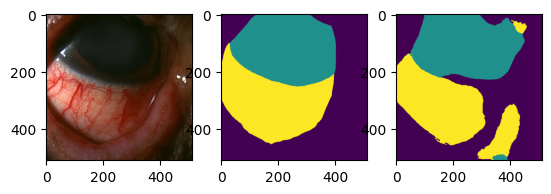

(512, 512)


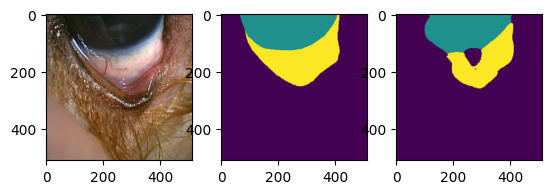

(512, 512)


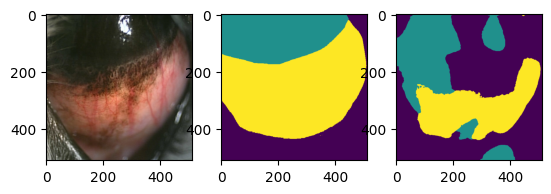

(512, 512)


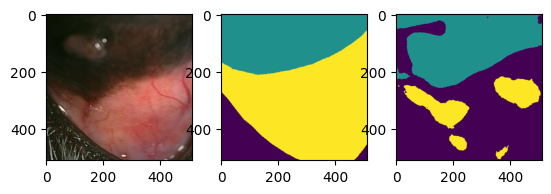

(512, 512)


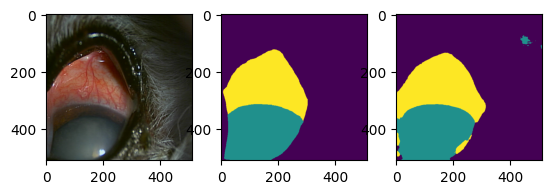

(512, 512)


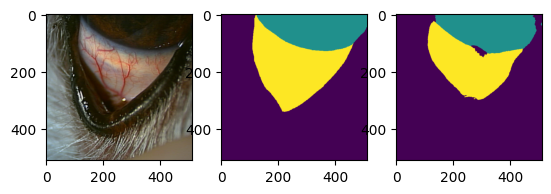

(512, 512)


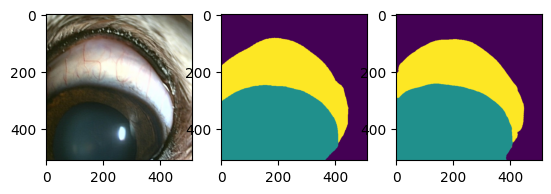

(512, 512)


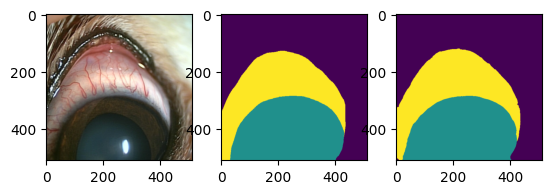

(512, 512)


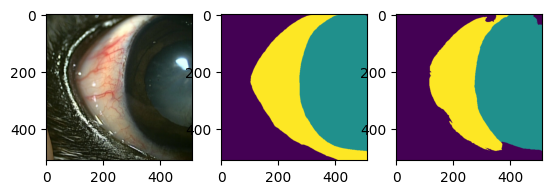

(512, 512)


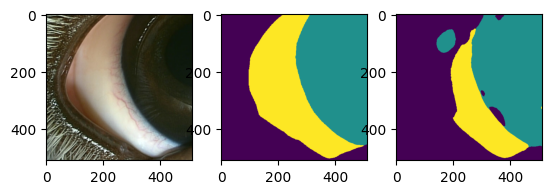

In [4]:
from torchvision import transforms
ds = ConjDataset(mode='val', normalization=False)
module = module.eval().to('cuda')
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

for i in range(len(test_ds)):
    image, label = ds[i]
    x = image
    with torch.no_grad():
        x = transform((x/255)[None, ...]).to('cuda')
        y = module(x)[0]
    
    # ここを変更: permute ではなく transpose を使用
    y = y.detach().cpu().numpy()
    y = y.transpose(1, 2, 0).argmax(axis=-1)
    print(y.shape)
    
    plt.subplot(1,3,1)
    plt.imshow(Image.fromarray((image.numpy().transpose(1, 2, 0)).astype(np.uint8)))
    plt.subplot(1,3,2)
    plt.imshow(label.numpy())
    plt.subplot(1,3,3)
    plt.imshow(y)
    plt.show()